In [248]:
#імпорт бібліотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

In [383]:
#завантаження даних
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')



#На случай моделинга
# target = train_data['target']
# train_data.drop(['target'], axis=1, inplace=True)

In [250]:
#знаходження кількості рядків/колонок(полів) у обох датасетах
test_data.shape , train_data.shape

test_len = test_data.shape[0]
train_len = train_data.shape[0]

У test - 13228 записів, 51 - полів (без target), train - відповідно 30860 записів тв 52 колонки

Глянемо на випадкові 10 записів з обох датасетів

In [211]:
# test_data.sample(10)

In [212]:
# train_data.sample(10)

In [213]:
#перевірка відповідності типів даних
# train_data.dtypes

In [214]:
#перевірка відповідності типів даних (тільки для test) 
# test_data.dtypes

<AxesSubplot:>

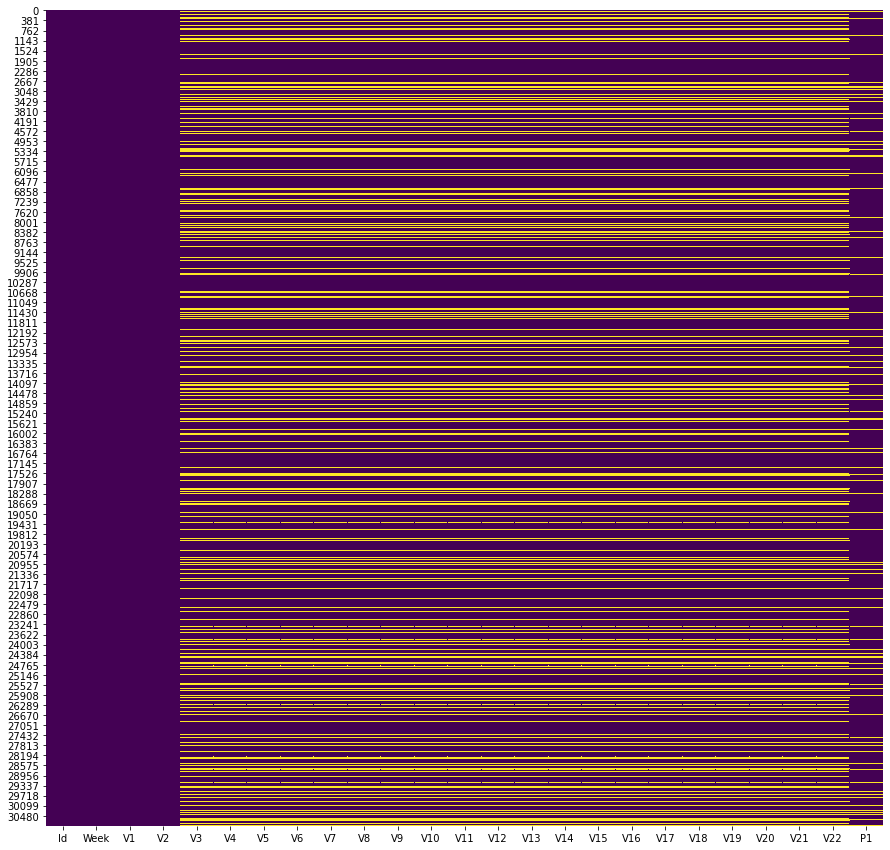

In [215]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_data.iloc[:, :25].isnull(), cbar=False, cmap='viridis')

<AxesSubplot:>

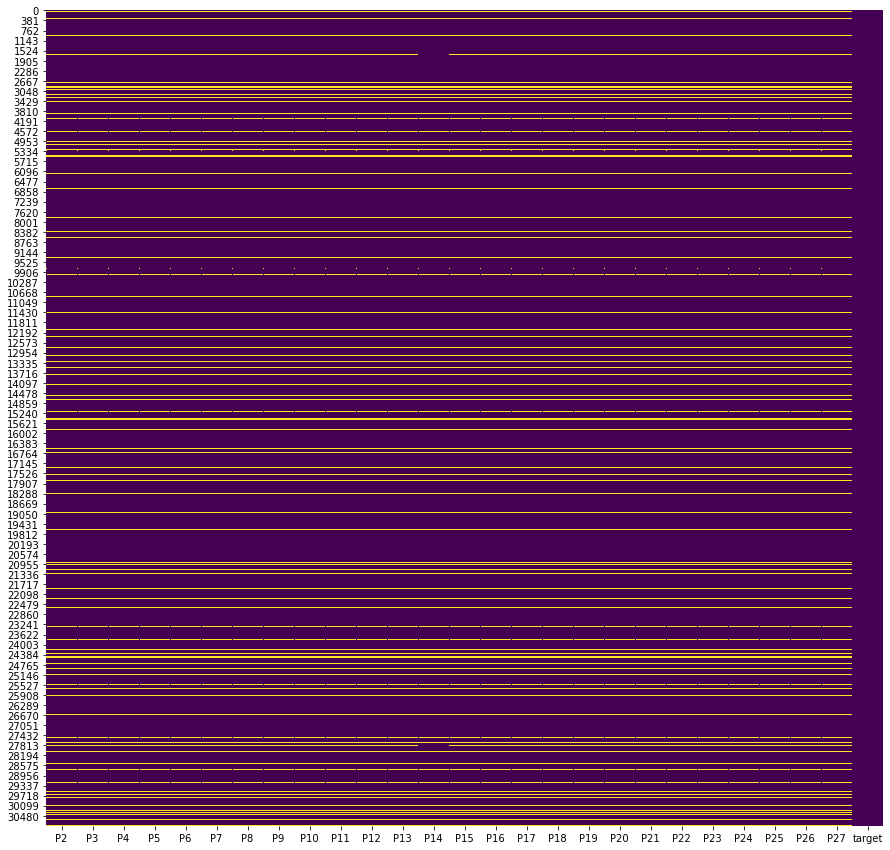

In [216]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_data.iloc[:, 25:].isnull(), cbar=False, cmap='viridis')

У вишек больше "одновременных" нулей, чем в пэшках.
Что вообще эти х-стики могут значить?

<AxesSubplot:>

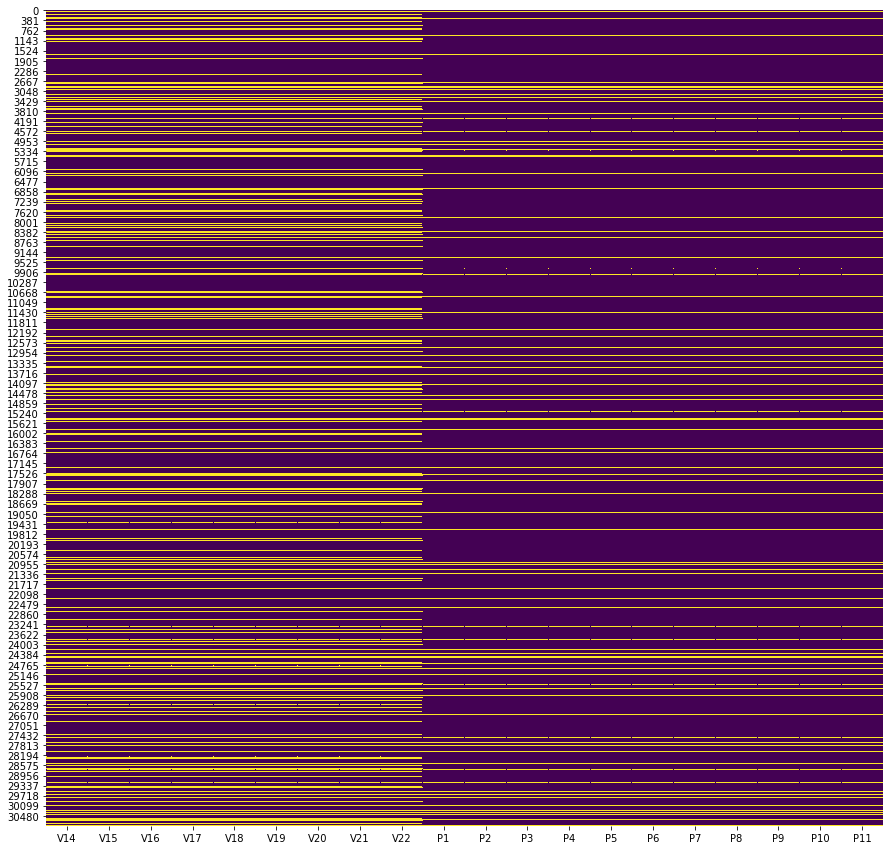

In [217]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_data.iloc[:, 15:35].isnull(), cbar=False, cmap='viridis')

А вот по этому видно, что: 
    
**нули в P -> нули в V** , НО:
    
**нули в V -/> нули в P**

### Процентик пропущенных 

In [218]:
# train_data.isnull().sum() / train_len
# test_data.isnull().sum() / test_len

На вешках стабильно **23%**, на п-ках **7%**
Стабильно на трейне/тесте

### Нулевые айдишики ????

In [219]:
# train_data[train_data['Id'] < 0 ]

Ого, их ровно половина

In [220]:
# test_data[test_data['Id'] < 0 ]

А че это может значить ??????

Может это проверка на тупость?
Взяли чисто из равномерного распредения и всё

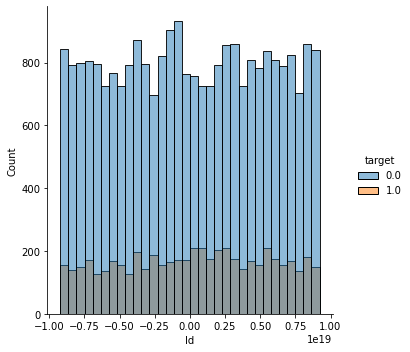

In [221]:
sns.displot(x='Id', data=train_data, hue='target')

In [222]:
# sns.displot(x='Id', data=test_data, hue='target');

Да, это проверка на тупость.

**== равномерное распр *1e9**

### Одновременные нули  

Годная идея кстати..

UPD: нет, по хитмапу всё видно

***Как определить главную фичу для V/P группы?***

Гипотеза 1: первая в каждой группе главная 

Гипотеза 2: их могли перемешать и она может не быть на 1 месте..

Не, думаю поиск тут будет не нужен. Какой смысл что-то определять ?

Одновременно V3 и дальше..

### Проверка на анамалии...
 
Вроде же все >=0 есть ли меньше 0?

In [223]:
V_indexes = list(train_data.columns[2:24])
P_indexes = list(train_data.columns[24:51])

In [224]:
train_data.loc[:, V_indexes[20:]].describe()

,V21,V22
count,23760.000000,23760.000000
mean,0.050111,0.007008
std,0.094222,0.024738
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.016139,0.000000
75%,0.051229,0.004679
max,0.922134,0.595517


В V меньше нуля нету

In [225]:
test_data.loc[:, P_indexes[15:]].describe()

,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27
count,12016.000000,12017.000000,12016.000000,12017.000000,12016.000000,12017.000000,12016.000000,12017.000000,12016.000000,12017.000000,12016.000000,12016.000000
mean,0.205296,12.241247,10864.133576,26.879603,4.944643,9.041766,325.545190,0.008792,4.939948,0.482257,3199.689913,0.337699
std,0.146375,246.114406,4773.711619,25.090967,0.058585,3.135939,144.332202,0.041819,0.061329,0.327837,3098.088692,0.250679
min,0.000000,0.039216,831.500000,0.450000,4.460000,0.150000,45.000000,0.000000,4.443333,0.000000,0.000000,0.000000
25%,0.093750,5.905702,7460.900090,15.833333,4.920000,7.515185,227.000000,0.000000,4.918932,0.172414,1386.750000,0.138889
50%,0.200000,7.579710,10109.582543,20.716667,4.960000,8.466111,295.000000,0.000000,4.957847,0.508772,2218.000000,0.285714
75%,0.296296,9.781818,13361.541302,30.300000,4.990000,9.747436,394.000000,0.000000,4.980000,0.769231,3870.500000,0.500000
max,1.000000,25724.500000,50715.000000,485.433333,5.000000,109.358333,1451.000000,1.000000,5.000000,1.000000,50715.000000,1.000000


В P тоже

### Лог трансформация?

UPD: пока не буду, это хард. Тут свои выбросы присутсвуют

Вот че делать с экспон. распред везде? Оно норм не трансформится (сразу в двумодальную)

**ПОПРОБУЮ:**  x -> 1 / x, 

UPD: работает хуже чем log10

Только трансформится в двумодальную, да

In [226]:
# from scipy.stats import boxcox

Распредения (кроме айдишки)

In [227]:
# for i in range(2, len(train_data.columns)):
#     sns.displot((train_data[train_data.columns[i]]+0.001), kind="kde")
#     plt.show()

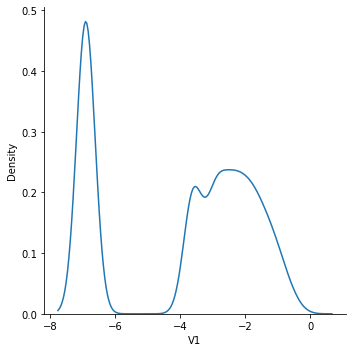

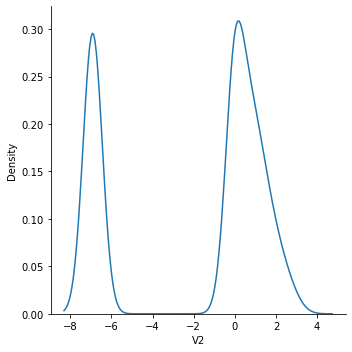

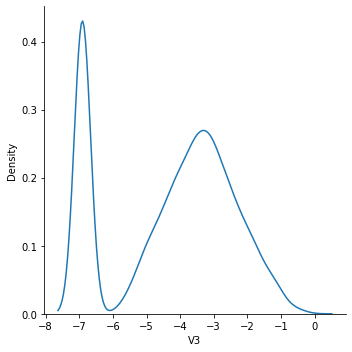

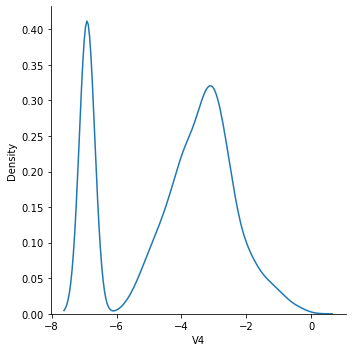

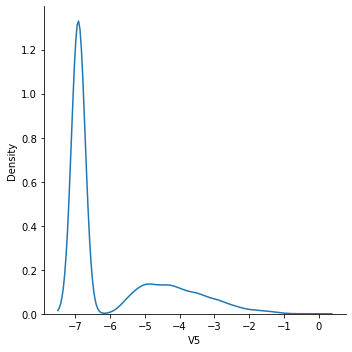

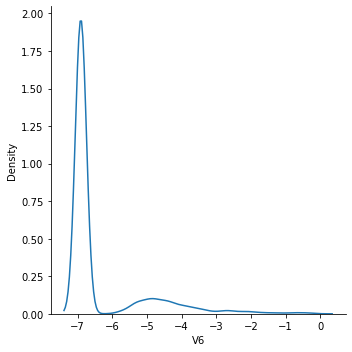

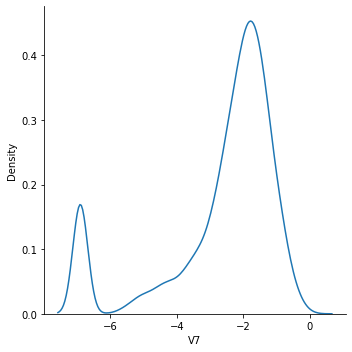

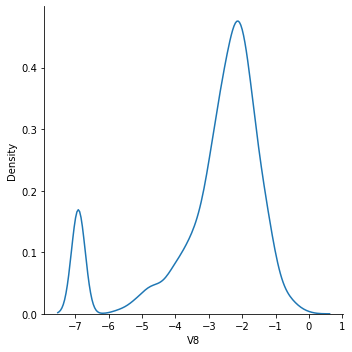

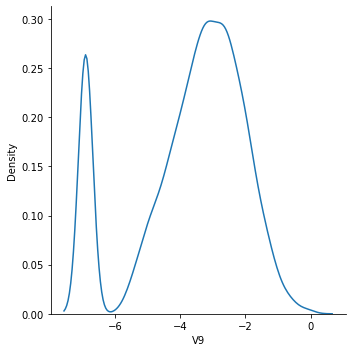

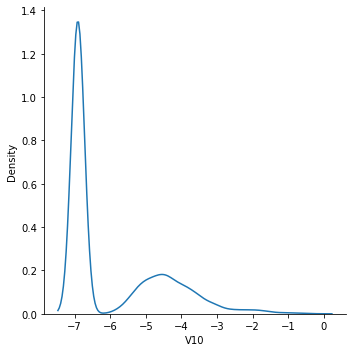

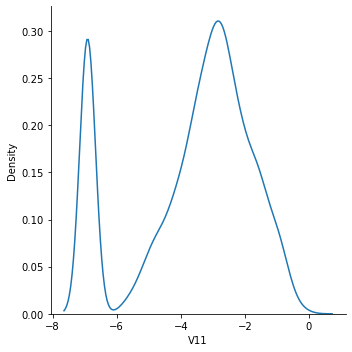

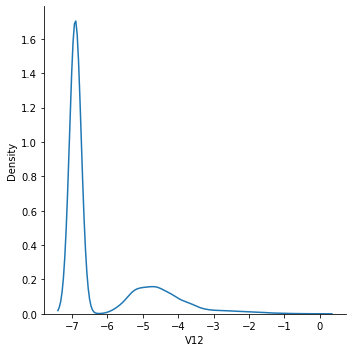

KeyboardInterrupt: 

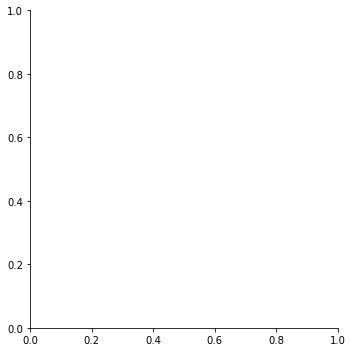

In [228]:
for i in range(2, len(train_data.columns)):
    sns.displot(np.log(train_data[train_data.columns[i]]+0.001), kind="kde")
    plt.show()


Я бы дропнул пару колонок сразу, но лучше пока не..

### Проверим на категориональные

нема, 

есть те, у которые просто все значения на одном

In [192]:
# Week 
# V1
# V2
# P1
# P12
# P20
# Week
# Target

In [229]:
cat_feats = ['Week', 'V1', 'V2', 'P1', 'P12', 'P20']

Сначала по std..

In [230]:
# for i in train_data.columns:
#     print(i, train_data[i].nunique())
#     plt.show()


### Прикольно, V2

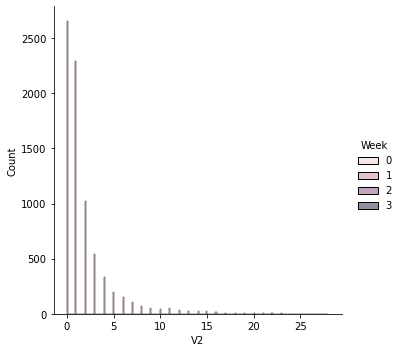

In [231]:
sns.displot(data=train_data, x='V2', hue='Week')

### Коэф вариации 

Думаю не надо

In [ ]:
# for col in train_data.columns[2:-1]:
#     print("CV of ", col, " - ",np.std(train_data[col])/np.mean(train_data[col])*100)

P12, P20, P24 мають низький коефіцієнт варіації, тому є сенс не враховувати колонки з низькою величиною CV.

Є сенс видалити у майбутньому ці поля

### Проверкочка на мультиколлинеарность 

In [ ]:
lst = []
corr = train_data.corr()

for i, col1 in enumerate(train_data.columns):
    for col2 in train_data.columns[i:]:
        if col1 == col2:
            continue
        else:
            if np.abs(corr[col1][col2]) > 0.5:
                print((col1, col2), corr[col1][col2])

Чесн говоря, многовато (40). Но пока оставлю так

### Препроцессинг: 
    
+ Дропаем айди 
+ Сначала трансформация в np.log10 все вишек / пишек
+ Приводим всё в ранг от 0 до 1
+ Потом все нули в P -> -1 
+ Нули в V, где в P -1 -> -1
+ Нули в V, где P не ноль  -> -2
+ Колоночка нолики в V 
+ Колоночка нолики в P
+ Колоночка нолики одновременно в P и V
+ Колоночка нолики только в V
+ Week делаем one-hot enc без одной

In [308]:
def preprocessing(data):
    
    """
    Подаём без таргета, хотя без разницы он все равно от 0 до 1..
    """
    
#     #Дропаем айди
#     data.drop(['Id'], axis=1, inplace=True)
    
    
    
    #Транс вишки
#     for i in V_indexes:
#         data[i] = np.log10(data[i]+0.001)
#         data[i] = 1 / (data[i]+0.001)
        
        
        
    #Транс пишки
#     for i in P_indexes:
#         data[i] = np.log10(data[i]+0.001)
#         data[i] = 1 / (data[i]+0.001)
        
    
    #В том числе и айдишка
    
    #V/P в ранг -> [0, 1], пропускаем первую колонку (Week)
    scaler = MinMaxScaler()
    data.iloc[:, 0:] = scaler.fit_transform(data.iloc[:, 0:])
        
    
    
    #Колоночка для только P
    data['Null_in_P'] = data['P1'].isna().map(lambda x: 1 if x else 0)
    

    
    #Колоночка для только V
    data['Null_in_V'] = data['V3'].isna().map(lambda x: 1 if x else 0)
    
    
    
    #Нули одновременно в V и P:
    
    data['Null_in_V_and_P'] = 0
    ser=(data['Null_in_P'] & data['Null_in_V']).map(lambda x: True if x else False)
    data.loc[ser, 'Null_in_V_and_P'] = 1
    
    
    
    #Нули только в V без P:
    data['Null_in_V_only'] = 0
    ser=(~data['Null_in_P'] & data['Null_in_V']).map(lambda x: True if x else False)
    data.loc[ser, 'Null_in_V_only'] = 1
    
    
    
    #Заполнение нулей в P:
    data.loc[:, P_indexes] = data.loc[:, P_indexes].fillna(-1)
    
    
    
    #Заполнение нулей в V, где есть нули в P:
    ser=(data['Null_in_P'] & data['Null_in_V']).map(lambda x: True if x else False)
    data.loc[ser, V_indexes] = data.loc[ser, V_indexes].fillna(-1)
    
    
    
    #Заполнение нулей в V, где нет нулей в P:
    ser=(~data['Null_in_P'] & data['Null_in_V']).map(lambda x: True if x else False)
    data.loc[ser, V_indexes] = data.loc[ser, V_indexes].fillna(-2)
    
    

#     Категориональные данные
    for feat in cat_feats:
        data[feat] = data[feat].astype(str)


#     #Ван-хот энкодинг Week
#     week_dummies = pd.get_dummies(data['Week'], prefix='Week', drop_first=True)
#     data = pd.concat([data, week_dummies], axis=1)
#     data.drop(['Week'], axis=1, inplace=True)
    
    
    
    
    
    return data

    
    

In [309]:
train_data_tr = preprocessing(train_data)
test_data_tr = preprocessing(test_data)

target = train_data_tr['target']
train_data_tr.drop(['target'], axis=1, inplace=True)

In [310]:
train_data_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30860 entries, 0 to 30859
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               30860 non-null  float64
 1   Week             30860 non-null  object 
 2   V1               30860 non-null  object 
 3   V2               30860 non-null  object 
 4   V3               30860 non-null  float64
 5   V4               30860 non-null  float64
 6   V5               30860 non-null  float64
 7   V6               30860 non-null  float64
 8   V7               30860 non-null  float64
 9   V8               30860 non-null  float64
 10  V9               30860 non-null  float64
 11  V10              30860 non-null  float64
 12  V11              30860 non-null  float64
 13  V12              30860 non-null  float64
 14  V13              30860 non-null  float64
 15  V14              30860 non-null  float64
 16  V15              30860 non-null  float64
 17  V16         

In [234]:
# for i in range(0, len(train_data_tr.columns)):
#     sns.displot((train_data_tr[train_data_tr.columns[i]]+0.001), kind="kde")
#     plt.show()

### PCA?

In [235]:
# from sklearn.decomposition import PCA

In [236]:
# pca = PCA(n_components=40)
# train_data_tr_pca = pca.fit_transform(train_data_tr)

In [237]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))

### Моделинг

In [311]:
X_train, X_test, y_train, y_test = train_test_split(
        train_data_tr, target, 
        stratify=target, test_size=0.2, 
        random_state=41)

In [312]:
# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

In [313]:
type(train_data_tr.at[0, "Week"])

str

In [314]:
cat_feats

['Week', 'V1', 'V2', 'P1', 'P12', 'P20']

In [339]:
from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool


# lgbm = LGBMClassifier(metric='AUC', random_state=42, categorical_feature=cat_feats)
# xg = XGBClassifier(random_state=42, eval_metric='auc')
# catboost = CatBoostClassifier(eval_metric='AUC', random_state=42, cat_features=cat_feats)

# lgbm.fit(X_train, y_train)
# xg.fit(X_train, y_train)
# catboost.fit(X_train, y_train)


# print(xg.score(X_test, y_test))

# print(lgbm.score(X_test, y_test))
# print(lgbm.score(X_train, y_train))

# print(catboost.score(X_test, y_test))
# print(catboost.score(X_train, y_train))

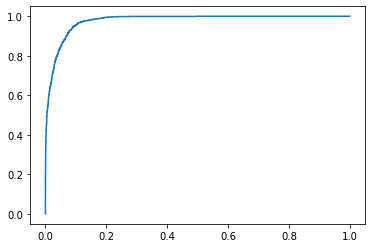

In [344]:
probs = catboost.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, thresholds = roc_curve(y_test, preds)

plt.plot(fpr, tpr)

In [417]:
train_pool = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_feats
)

validation_pool = Pool(
    data = X_test,
    label = y_test,
    cat_features = cat_feats
)

catboost_tuned = CatBoostClassifier(
    iterations = 2000,
    loss_function='Logloss',
    custom_metric = ["AUC"],
    early_stopping_rounds = 300)

catboost_tuned.fit(train_pool, 
          eval_set =  validation_pool,
          verbose = 100, 
          plot = True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04947
0:	learn: 0.6396696	test: 0.6401540	best: 0.6401540 (0)	total: 90.8ms	remaining: 3m 1s
100:	learn: 0.2336621	test: 0.2497785	best: 0.2497785 (100)	total: 11.6s	remaining: 3m 37s
200:	learn: 0.2054196	test: 0.2280832	best: 0.2280832 (200)	total: 21.3s	remaining: 3m 10s
300:	learn: 0.1849236	test: 0.2140161	best: 0.2140161 (300)	total: 31.3s	remaining: 2m 56s
400:	learn: 0.1682670	test: 0.2031159	best: 0.2031159 (400)	total: 42.1s	remaining: 2m 47s
500:	learn: 0.1561931	test: 0.1946037	best: 0.1946037 (500)	total: 51s	remaining: 2m 32s
600:	learn: 0.1455733	test: 0.1880905	best: 0.1880599 (598)	total: 1m 1s	remaining: 2m 24s
700:	learn: 0.1363949	test: 0.1834983	best: 0.1834983 (700)	total: 1m 12s	remaining: 2m 14s
800:	learn: 0.1288501	test: 0.1790035	best: 0.1790035 (800)	total: 1m 23s	remaining: 2m 5s
900:	learn: 0.1223698	test: 0.1755164	best: 0.1755164 (900)	total: 1m 33s	remaining: 1m 53s
1000:	learn: 0.1164052	test: 0.1720272	best: 0.1720272 (1000)	tot

In [327]:
print(catboost_tuned.score(X_test, y_test))
print(catboost_tuned.score(X_train, y_train))

0.9402138690861958
0.9695398574206092


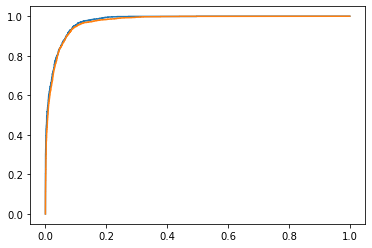

In [422]:
probs_ = catboost_tuned.predict_proba(X_test)
preds_ = probs_[:,1]

fpr_, tpr_, thresholds_ = roc_curve(y_test, preds_)

plt.plot(fpr, tpr)
plt.plot(fpr_, tpr_)

In [427]:
from sklearn.metrics import roc_auc_score, auc




# roc_auc_score(y_train, catboost_tuned.predict(X_train))
auc(fpr_, tpr_)


0.9738347065942005

### Optuna

In [424]:
# !pip install optuna

In [426]:
import optuna

In [438]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(train_data_tr, target, test_size=0.2)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "iterations" : 2000,
        "loss_function":'Logloss',
        "custom_metric" : ["AUC"]
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_temp = CatBoostClassifier(**param)

    cat_temp.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=100, early_stopping_rounds=300,
                          plot = True)
    
    preds = catboost_tuned.predict_proba(valid_x)[:,1]

    fpr, tpr, thresholds_ = roc_curve(valid_y, preds)

    auc_score = auc(fpr, tpr)

    return auc_score

In [440]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=600)

[I 2022-01-23 17:26:26,456] A new study created in memory with name: no-name-9ff21153-0ca3-43fe-b0e2-43e7555975d7
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6712609	test: 0.6711946	best: 0.6711946 (0)	total: 11.5ms	remaining: 23.1s
100:	learn: 0.3401027	test: 0.3354201	best: 0.3354201 (100)	total: 634ms	remaining: 11.9s
200:	learn: 0.3145499	test: 0.3081401	best: 0.3081401 (200)	total: 1.32s	remaining: 11.8s
300:	learn: 0.3031814	test: 0.2964959	best: 0.2964959 (300)	total: 1.99s	remaining: 11.2s
400:	learn: 0.2942661	test: 0.2874974	best: 0.2874974 (400)	total: 2.62s	remaining: 10.4s
500:	learn: 0.2881314	test: 0.2813905	best: 0.2813855 (499)	total: 3.24s	remaining: 9.69s
600:	learn: 0.2839230	test: 0.2774517	best: 0.2774517 (600)	total: 3.86s	remaining: 8.99s
700:	learn: 0.2807007	test: 0.2746854	best: 0.2746854 (700)	total: 4.59s	remaining: 8.5s
800:	learn: 0.2781663	test: 0.2723856	best: 0.2723856 (800)	total: 5.28s	remaining: 7.9s
900:	learn: 0.2757819	test: 0.2702344	best: 0.2702344 (900)	total: 5.9s	remaining: 7.2s
1000:	learn: 0.2736986	test: 0.2684946	best: 0.2684904 (999)	total: 6.59s	remaining: 6.58s
1100:	learn: 0.2

[I 2022-01-23 17:26:41,356] Trial 0 finished with value: 0.9895055904848677 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07267979461273809, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9895055904848677.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6781841	test: 0.6779967	best: 0.6779967 (0)	total: 13.2ms	remaining: 26.3s
100:	learn: 0.3119958	test: 0.3129514	best: 0.3129514 (100)	total: 2.31s	remaining: 43.5s
200:	learn: 0.2805355	test: 0.2841406	best: 0.2841406 (200)	total: 4.74s	remaining: 42.4s
300:	learn: 0.2660208	test: 0.2721302	best: 0.2721302 (300)	total: 7.58s	remaining: 42.8s
400:	learn: 0.2578071	test: 0.2657363	best: 0.2657363 (400)	total: 10.9s	remaining: 43.3s
500:	learn: 0.2500374	test: 0.2596777	best: 0.2596777 (500)	total: 13.3s	remaining: 39.9s
600:	learn: 0.2445138	test: 0.2558904	best: 0.2558904 (600)	total: 15.5s	remaining: 36.1s
700:	learn: 0.2388418	test: 0.2517615	best: 0.2517615 (700)	total: 17.9s	remaining: 33.1s
800:	learn: 0.2331184	test: 0.2477214	best: 0.2477214 (800)	total: 20.3s	remaining: 30.3s
900:	learn: 0.2297687	test: 0.2454524	best: 0.2454521 (898)	total: 22.4s	remaining: 27.3s
1000:	learn: 0.2263752	test: 0.2430817	best: 0.2430817 (1000)	total: 24.7s	remaining: 24.7s
1100:	learn

[I 2022-01-23 17:27:30,017] Trial 1 finished with value: 0.9898543494478164 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.025905270321186447, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9272392472562397}. Best is trial 1 with value: 0.9898543494478164.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6647087	test: 0.6651778	best: 0.6651778 (0)	total: 31.8ms	remaining: 1m 3s
100:	learn: 0.2655558	test: 0.2878092	best: 0.2878092 (100)	total: 3.26s	remaining: 1m 1s
200:	learn: 0.2336944	test: 0.2695074	best: 0.2695074 (200)	total: 6.5s	remaining: 58.2s
300:	learn: 0.2127115	test: 0.2612915	best: 0.2612915 (300)	total: 9.59s	remaining: 54.1s
400:	learn: 0.1951736	test: 0.2545987	best: 0.2545987 (400)	total: 12.8s	remaining: 51s
500:	learn: 0.1822148	test: 0.2503510	best: 0.2503510 (500)	total: 15.9s	remaining: 47.5s
600:	learn: 0.1714708	test: 0.2472998	best: 0.2472848 (599)	total: 19.1s	remaining: 44.4s
700:	learn: 0.1624055	test: 0.2447729	best: 0.2447729 (700)	total: 22.1s	remaining: 41s
800:	learn: 0.1534596	test: 0.2420059	best: 0.2420059 (800)	total: 25.4s	remaining: 38s
900:	learn: 0.1461499	test: 0.2402051	best: 0.2402051 (900)	total: 28.5s	remaining: 34.8s
1000:	learn: 0.1389246	test: 0.2384779	best: 0.2384779 (1000)	total: 32s	remaining: 31.9s
1100:	learn: 0.13293

[I 2022-01-23 17:28:38,071] Trial 2 finished with value: 0.9899104480225032 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0703981787556667, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.829791176474025}. Best is trial 2 with value: 0.9899104480225032.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6709435	test: 0.6709656	best: 0.6709656 (0)	total: 22.4ms	remaining: 44.8s
100:	learn: 0.2567661	test: 0.2821877	best: 0.2821877 (100)	total: 39.1s	remaining: 12m 14s
200:	learn: 0.2233844	test: 0.2623172	best: 0.2623172 (200)	total: 1m 25s	remaining: 12m 45s
300:	learn: 0.2027104	test: 0.2517946	best: 0.2517946 (300)	total: 2m 5s	remaining: 11m 48s
400:	learn: 0.1872582	test: 0.2435020	best: 0.2435020 (400)	total: 2m 49s	remaining: 11m 14s
500:	learn: 0.1752452	test: 0.2367007	best: 0.2367007 (500)	total: 3m 32s	remaining: 10m 35s
600:	learn: 0.1666448	test: 0.2322603	best: 0.2322603 (600)	total: 4m 15s	remaining: 9m 55s
700:	learn: 0.1590699	test: 0.2285351	best: 0.2285351 (700)	total: 4m 59s	remaining: 9m 15s
800:	learn: 0.1516298	test: 0.2255415	best: 0.2255415 (800)	total: 5m 42s	remaining: 8m 32s
900:	learn: 0.1447698	test: 0.2221833	best: 0.2221833 (900)	total: 6m 26s	remaining: 7m 51s
1000:	learn: 0.1387716	test: 0.2191802	best: 0.2191802 (1000)	total: 7m 16s	remain

[I 2022-01-23 17:43:37,178] Trial 3 finished with value: 0.9899588114504823 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07671332664435097, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.12380380066857671}. Best is trial 3 with value: 0.9899588114504823.


### CatBoost + Optuna

In [446]:
# optuna_params = {'objective': 'CrossEntropy', 
#                  'colsample_bylevel': 0.07671332664435097, 
#                  'depth': 11, 
#                  'boosting_type': 'Ordered', 
#                  'bootstrap_type': 'Bernoulli', 
#                  'subsample': 0.12380380066857671, 
#                  "used_ram_limit": "3gb",
#                  "iterations" : 2000,
#                  "loss_function":'Logloss',
#                  "custom_metric" : ["AUC"]}


optuna_params = { 'iterations' : 5000, 'depth' : 8,
                   'learning_rate' : 0.13851548141121092/8,
                   'colsample_bylevel' : 0.42513600460183565/8,
                   'bagging_temperature' : 3.7987780158429185/8,
                   'early_stopping_rounds': 500/2, 'random_seed' : 42,
                   'loss_function' : 'Logloss','eval_metric' : 'AUC',
                   'boosting_type' : 'Plain','bootstrap_type' : 'MVS',
                   'task_type' : 'CPU', 'cat_features' : cat_feats}

In [447]:
catboost_optuna = CatBoostClassifier(**optuna_params)

catboost_optuna.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100, early_stopping_rounds=300,
                      plot = True)

preds = catboost_optuna.predict_proba(X_test)[:,1]

fpr, tpr, thresholds_ = roc_curve(y_test, preds)

auc_score = auc(fpr, tpr)
auc_score

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8196108	best: 0.8196108 (0)	total: 31.6ms	remaining: 2m 38s
100:	test: 0.9031274	best: 0.9031274 (100)	total: 3.67s	remaining: 2m 58s
200:	test: 0.9177393	best: 0.9177393 (200)	total: 7.59s	remaining: 3m 1s
300:	test: 0.9257872	best: 0.9257872 (300)	total: 12s	remaining: 3m 6s
400:	test: 0.9313794	best: 0.9313893 (399)	total: 16s	remaining: 3m 3s
500:	test: 0.9354909	best: 0.9354909 (500)	total: 20.5s	remaining: 3m 4s
600:	test: 0.9398661	best: 0.9398661 (600)	total: 24.6s	remaining: 2m 59s
700:	test: 0.9428162	best: 0.9428162 (700)	total: 28.5s	remaining: 2m 55s
800:	test: 0.9456631	best: 0.9456631 (800)	total: 32.9s	remaining: 2m 52s
900:	test: 0.9472949	best: 0.9472949 (900)	total: 36.8s	remaining: 2m 47s
1000:	test: 0.9493800	best: 0.9493800 (1000)	total: 41.4s	remaining: 2m 45s
1100:	test: 0.9509969	best: 0.9509992 (1099)	total: 45.7s	remaining: 2m 41s
1200:	test: 0.9524179	best: 0.9524179 (1200)	total: 50.2s	remaining: 2m 38s
1300:	test: 0.9537352	best: 0.9537352 (1300

0.9675698431081527

In [453]:
n_splits = 3

X = train_data_tr
y = target

optuna_clfs = []
kFold_random_state = [42]#, 69, 666, 228]#, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

for ind_k, random_state in enumerate(kFold_random_state):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = CatBoostClassifier(**optuna_params)
        optuna_clfs.append(clf)

        clf.fit(train_data_tr, target,
                verbose=100, plot=True, use_best_model = True)



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 22.2ms	remaining: 1m 51s
100:	total: 3.94s	remaining: 3m 11s
200:	total: 8.2s	remaining: 3m 15s
300:	total: 12.6s	remaining: 3m 17s
400:	total: 17.5s	remaining: 3m 20s
500:	total: 22.5s	remaining: 3m 22s
600:	total: 27.8s	remaining: 3m 23s
700:	total: 33.5s	remaining: 3m 25s
800:	total: 38.7s	remaining: 3m 22s
900:	total: 44.4s	remaining: 3m 22s
1000:	total: 49.9s	remaining: 3m 19s
1100:	total: 55.4s	remaining: 3m 16s
1200:	total: 1m	remaining: 3m 12s
1300:	total: 1m 6s	remaining: 3m 9s
1400:	total: 1m 12s	remaining: 3m 5s
1500:	total: 1m 17s	remaining: 3m
1600:	total: 1m 23s	remaining: 2m 56s
1700:	total: 1m 28s	remaining: 2m 52s
1800:	total: 1m 34s	remaining: 2m 48s
1900:	total: 1m 40s	remaining: 2m 43s
2000:	total: 1m 46s	remaining: 2m 38s
2100:	total: 1m 51s	remaining: 2m 33s
2200:	total: 1m 57s	remaining: 2m 29s
2300:	total: 2m 2s	remaining: 2m 23s
2400:	total: 2m 8s	remaining: 2m 19s
2500:	total: 2m 14s	remaining: 2m 14s
2600:	total: 2m 20s	remaining: 2m 9s
2700:	total:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 44.6ms	remaining: 3m 42s
100:	total: 5.04s	remaining: 4m 4s
200:	total: 11.6s	remaining: 4m 36s
300:	total: 16.4s	remaining: 4m 16s
400:	total: 21.6s	remaining: 4m 7s
500:	total: 26.7s	remaining: 3m 59s
600:	total: 32.2s	remaining: 3m 55s
700:	total: 37.4s	remaining: 3m 49s
800:	total: 42.6s	remaining: 3m 43s
900:	total: 48.2s	remaining: 3m 39s
1000:	total: 53.5s	remaining: 3m 33s
1100:	total: 58.8s	remaining: 3m 28s
1200:	total: 1m 4s	remaining: 3m 23s
1300:	total: 1m 9s	remaining: 3m 17s
1400:	total: 1m 15s	remaining: 3m 13s
1500:	total: 1m 20s	remaining: 3m 7s
1600:	total: 1m 25s	remaining: 3m 1s
1700:	total: 1m 31s	remaining: 2m 57s
1800:	total: 1m 37s	remaining: 2m 52s
1900:	total: 1m 42s	remaining: 2m 47s
2000:	total: 1m 48s	remaining: 2m 42s
2100:	total: 1m 53s	remaining: 2m 37s
2200:	total: 1m 59s	remaining: 2m 31s
2300:	total: 2m 4s	remaining: 2m 26s
2400:	total: 2m 10s	remaining: 2m 21s
2500:	total: 2m 16s	remaining: 2m 16s
2600:	total: 2m 21s	remaining: 2m 10s
2700

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	total: 50.3ms	remaining: 4m 11s
100:	total: 5.06s	remaining: 4m 5s
200:	total: 11s	remaining: 4m 23s
300:	total: 16.4s	remaining: 4m 16s
400:	total: 22.3s	remaining: 4m 15s
500:	total: 28.1s	remaining: 4m 12s
600:	total: 34.3s	remaining: 4m 11s
700:	total: 40.4s	remaining: 4m 7s
800:	total: 47s	remaining: 4m 6s
900:	total: 53.3s	remaining: 4m 2s
1000:	total: 59.3s	remaining: 3m 57s
1100:	total: 1m 5s	remaining: 3m 50s
1200:	total: 1m 11s	remaining: 3m 45s
1300:	total: 1m 17s	remaining: 3m 40s
1400:	total: 1m 23s	remaining: 3m 34s
1500:	total: 1m 29s	remaining: 3m 28s
1600:	total: 1m 35s	remaining: 3m 23s
1700:	total: 1m 42s	remaining: 3m 17s
1800:	total: 1m 49s	remaining: 3m 14s
1900:	total: 1m 55s	remaining: 3m 8s
2000:	total: 2m 2s	remaining: 3m 2s
2100:	total: 2m 8s	remaining: 2m 57s
2200:	total: 2m 14s	remaining: 2m 51s
2300:	total: 2m 20s	remaining: 2m 44s
2400:	total: 2m 27s	remaining: 2m 39s
2500:	total: 2m 34s	remaining: 2m 34s
2600:	total: 2m 40s	remaining: 2m 28s
2700:	tot

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=2]=0.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [455]:
len(test_data_tr)

13228

In [463]:
# массив для записи результата по нескольким фолдам
y_pred_optuna = np.zeros((len(test_data_tr),))
scores = []
for clf in optuna_clfs:
    y_pred_optuna += clf.predict_proba(test_data_tr)[:,1]

y_pred_optuna /= N
# print('mean AUC', np.mean(scores))

In [465]:
y_pred_optuna

array([6.74347349e-04, 6.28506447e-04, 5.32916208e-04, ...,
       5.61056094e-01, 8.77305404e-01, 1.97249157e-01])

### Треним на всём 

In [415]:
train_pool = Pool(
    data = train_data_tr,
    label = target,
    cat_features = cat_feats
)


catboost_tuned = CatBoostClassifier(
    iterations = 10000,
    loss_function='Logloss',
    custom_metric = ["AUC"],
    early_stopping_rounds = 300)

catboost_tuned.fit(train_pool,
          verbose = 100, 
          plot = True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.005394
0:	learn: 0.6874895	total: 98.4ms	remaining: 16m 23s
100:	learn: 0.3894523	total: 10.3s	remaining: 16m 46s


KeyboardInterrupt: 

In [362]:
test_data

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,...,P22,P23,P24,P25,P26,P27,Null_in_P,Null_in_V,Null_in_V_and_P,Null_in_V_only
0,0.830899,0.0,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.359175,0.00000,0.737382,0.902439,0.085202,0.642857,0,0,0,0
1,0.830899,0.3333333333333333,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.479374,0.00000,0.715141,0.904762,0.123533,0.714286,0,0,0,0
2,0.830899,0.6666666666666666,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.342105,0.00000,0.730539,0.900000,0.039495,0.821429,0,0,0,0
3,0.830899,1.0,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.392603,0.03125,0.730539,0.937500,0.021079,0.656250,0,0,0,0
4,0.401033,0.0,0.0,0.0,0.000000,0.205345,0.0,0.000000,0.333618,0.000000,...,0.105263,0.00000,0.964072,0.190476,0.047639,0.095238,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223,0.064354,1.0,0.0,0.0,0.010143,0.015827,0.0,0.000000,0.378547,0.324356,...,0.231152,0.00000,0.856287,0.730769,0.017825,0.538462,0,0,0,0
13224,0.510905,0.0,0.07905982905982892,0.041666666666666664,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1,1,1,0
13225,0.510905,0.3333333333333333,0.07905982905982892,0.041666666666666664,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1,1,1,0
13226,0.510905,0.6666666666666666,0.07905982905982892,0.041666666666666664,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,...,0.189189,0.00000,0.759281,0.000000,0.106477,0.200000,0,1,0,1


In [361]:
train_data_tr

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,...,P22,P23,P24,P25,P26,P27,Null_in_P,Null_in_V,Null_in_V_and_P,Null_in_V_only
0,0.145355,0.0,0.0,0.0,0.000000,0.012103,0.008178,0.036066,0.013246,0.006579,...,0.075962,0.000000,0.769968,0.333333,0.055890,0.333333,0,0,0,0
1,0.145355,0.3333333333333333,0.0,0.0,0.000000,0.012103,0.008178,0.036066,0.013246,0.006579,...,0.230885,0.000000,0.769968,0.652174,0.040577,0.391304,0,0,0,0
2,0.145355,0.6666666666666666,0.0,0.0,0.000000,0.012103,0.008178,0.036066,0.013246,0.006579,...,0.070965,0.000000,0.769968,0.500000,0.018111,0.181818,0,0,0,0
3,0.145355,1.0,0.0,0.0,0.000000,0.012103,0.008178,0.036066,0.013246,0.006579,...,0.166917,0.026316,0.763242,0.447368,0.034082,0.394737,0,0,0,0
4,0.405279,0.0,0.062271062271062175,0.03571428571428571,0.017809,0.019498,0.046780,0.000000,0.181450,0.103449,...,0.364318,0.021739,0.883039,0.673913,0.010792,0.239130,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30855,0.608901,1.0,0.13492063492063494,0.07142857142857142,0.007653,0.285044,0.000000,0.000000,0.193410,0.000000,...,0.178911,0.000000,0.957559,0.555556,0.008002,0.345679,0,0,0,0
30856,0.977246,0.0,0.03917050691244236,0.03571428571428571,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.092954,0.000000,0.974441,0.058824,0.028428,0.235294,0,1,0,1
30857,0.977246,0.3333333333333333,0.03917050691244236,0.03571428571428571,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.061469,0.000000,0.987220,0.000000,0.136778,1.000000,0,1,0,1
30858,0.977246,0.6666666666666666,0.03917050691244236,0.03571428571428571,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.085957,0.000000,0.987220,0.250000,0.038204,0.500000,0,1,0,1


### Предиктик

In [388]:
preds_final = catboost_tuned.predict_proba(test_data_tr)[:, 1]
preds_final

test_id = test_data['Id']

In [389]:
preds_final[4:8]

array([0.36706193, 0.1826611 , 0.47162661, 0.44047967])

In [466]:
sample_submission = pd.DataFrame()

sample_submission['Id'] = test_id
sample_submission['Predicted'] = y_pred_optuna
sample_submission

,Id,Predicted
0,6107424960806386948,0.000674
1,6107424960806386948,0.000629
2,6107424960806386948,0.000533
3,6107424960806386948,0.000393
4,-1808613790090531322,0.192073
...,...,...
13223,-8008599329977273072,0.001249
13224,214704124864576365,0.537693
13225,214704124864576365,0.561056
13226,214704124864576365,0.877305


In [471]:
sample_submission.groupby(by='Id', sort=False, as_index=True).mean().to_csv('sub_vi_2.csv')

In [469]:
df1 = sample_submission.groupby(by='Id', sort=False, as_index=False).mean()

In [470]:
df1

,Id,Predicted
0,6107424960806386948,0.000557
1,-1808613790090531322,0.207487
2,-2649749947427248381,0.779122
3,4684257435812939224,0.601996
4,-7030158396775705152,0.022722
...,...,...
3302,-2211304808281344572,0.002548
3303,6416554621804862174,0.043028
3304,-2318403417965670905,0.000772
3305,-8008599329977273072,0.002338


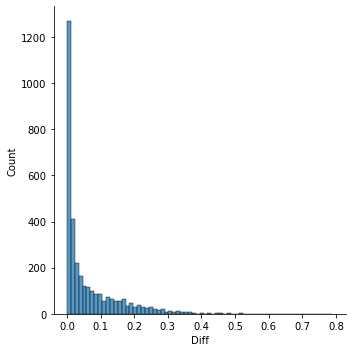

In [404]:
df = df1.merge( df2, on='Id', how="left")
df['Diff'] = np.abs(df['Predicted_x'] - df['Predicted_y'])

sns.displot(df['Diff'])

In [398]:
df2 = pd.read_csv('Result.csv')
# df2['Predicted2'] = 

In [402]:
df1.shape, df2.shape

((3307, 2), (3307, 2))

In [410]:
from sklearn.model_selection import KFold

In [414]:
n_splits = 3


clfs = []
X = train_data_tr 
y = target

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

for ind_k, random_state in enumerate(kFold_random_state):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = CatBoostClassifier(iterations = 10000,
                              loss_function = 'Logloss', eval_metric = 'AUC', #'AUC:hints=skip_train~false',
                              cat_features = cat_feats, random_seed=random_state,
                              early_stopping_rounds=250 + ind_k*10 )
        clfs.append(clf)

        clf.fit(X_train, y_train, eval_set=(X_test, y_test),
                verbose = 4, use_best_model = True, plot = False)
        
assert len(clfs) == N

# массив для записи финального результата
y_pred = np.zeros((len(test_data),))
scores = []
for clf in clfs:
    y_pred += clf.predict_proba(test_data)[:,1]
    scores.append(clf.best_score_['validation']['AUC'])
y_pred /= N
print('mean AUC', np.mean(scores))


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.024564
0:	test: 0.8557552	best: 0.8557552 (0)	total: 91.2ms	remaining: 15m 12s
4:	test: 0.8779250	best: 0.8779250 (4)	total: 446ms	remaining: 14m 51s
8:	test: 0.8849912	best: 0.8849912 (8)	total: 902ms	remaining: 16m 40s
12:	test: 0.8879231	best: 0.8879231 (12)	total: 1.36s	remaining: 17m 22s
16:	test: 0.8905315	best: 0.8905315 (16)	total: 1.71s	remaining: 16m 46s
20:	test: 0.8920791	best: 0.8920791 (20)	total: 2.08s	remaining: 16m 27s
24:	test: 0.8935573	best: 0.8935573 (24)	total: 2.42s	remaining: 16m 7s
28:	test: 0.8952436	best: 0.8952436 (28)	total: 2.78s	remaining: 15m 56s
32:	test: 0.8957793	best: 0.8958523 (31)	total: 3.13s	remaining: 15m 45s
36:	test: 0.8973162	best: 0.8973162 (36)	total: 3.48s	remaining: 15m 37s
40:	test: 0.8989492	best: 0.8989492 (40)	total: 3.83s	remaining: 15m 30s
44:	test: 0.8999603	best: 0.8999603 (44)	total: 4.28s	remaining: 15m 46s
48:	test: 0.9027863	best: 0.9027863 (48)	total: 4.63s	remaining: 15m 39s
52:	test: 0.9058956	best: 0

444:	test: 0.9473970	best: 0.9473970 (444)	total: 40.7s	remaining: 14m 34s
448:	test: 0.9475753	best: 0.9475780 (447)	total: 41.2s	remaining: 14m 36s
452:	test: 0.9477375	best: 0.9477375 (452)	total: 41.7s	remaining: 14m 38s
456:	test: 0.9478183	best: 0.9478183 (456)	total: 42s	remaining: 14m 38s
460:	test: 0.9479236	best: 0.9479236 (460)	total: 42.5s	remaining: 14m 40s
464:	test: 0.9480904	best: 0.9480904 (464)	total: 43s	remaining: 14m 42s
468:	test: 0.9482893	best: 0.9482893 (468)	total: 43.5s	remaining: 14m 44s
472:	test: 0.9484758	best: 0.9484758 (472)	total: 44.1s	remaining: 14m 47s
476:	test: 0.9486987	best: 0.9486987 (476)	total: 44.6s	remaining: 14m 50s
480:	test: 0.9488586	best: 0.9488586 (480)	total: 45.1s	remaining: 14m 53s
484:	test: 0.9489105	best: 0.9489105 (484)	total: 45.6s	remaining: 14m 55s
488:	test: 0.9491854	best: 0.9491862 (487)	total: 46s	remaining: 14m 54s
492:	test: 0.9493061	best: 0.9493061 (492)	total: 46.3s	remaining: 14m 53s
496:	test: 0.9494051	best: 0.94

884:	test: 0.9598470	best: 0.9598470 (884)	total: 1m 21s	remaining: 13m 55s
888:	test: 0.9599408	best: 0.9599408 (888)	total: 1m 21s	remaining: 13m 55s
892:	test: 0.9599980	best: 0.9599980 (892)	total: 1m 21s	remaining: 13m 54s
896:	test: 0.9601255	best: 0.9601255 (896)	total: 1m 22s	remaining: 13m 53s
900:	test: 0.9601694	best: 0.9601760 (899)	total: 1m 22s	remaining: 13m 53s
904:	test: 0.9602431	best: 0.9602431 (904)	total: 1m 22s	remaining: 13m 52s
908:	test: 0.9602547	best: 0.9602547 (908)	total: 1m 23s	remaining: 13m 52s
912:	test: 0.9603701	best: 0.9603701 (912)	total: 1m 23s	remaining: 13m 51s
916:	test: 0.9604457	best: 0.9604457 (916)	total: 1m 23s	remaining: 13m 50s
920:	test: 0.9605187	best: 0.9605193 (919)	total: 1m 24s	remaining: 13m 50s
924:	test: 0.9605687	best: 0.9605687 (924)	total: 1m 24s	remaining: 13m 50s
928:	test: 0.9606770	best: 0.9606770 (928)	total: 1m 25s	remaining: 13m 50s
932:	test: 0.9607100	best: 0.9607100 (932)	total: 1m 25s	remaining: 13m 50s
936:	test: 0

KeyboardInterrupt: 

In [348]:
test_data

,Id,Week,V1,V2,V3,V4,V5,V6,V7,V8,...,P22,P23,P24,P25,P26,P27,Null_in_P,Null_in_V,Null_in_V_and_P,Null_in_V_only
0,0.830899,0.0,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.359175,0.00000,0.737382,0.902439,0.085202,0.642857,0,0,0,0
1,0.830899,0.3333333333333333,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.479374,0.00000,0.715141,0.904762,0.123533,0.714286,0,0,0,0
2,0.830899,0.6666666666666666,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.342105,0.00000,0.730539,0.900000,0.039495,0.821429,0,0,0,0
3,0.830899,1.0,0.0,0.0,0.015697,0.028448,0.0,0.013947,0.032552,0.042432,...,0.392603,0.03125,0.730539,0.937500,0.021079,0.656250,0,0,0,0
4,0.401033,0.0,0.0,0.0,0.000000,0.205345,0.0,0.000000,0.333618,0.000000,...,0.105263,0.00000,0.964072,0.190476,0.047639,0.095238,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223,0.064354,1.0,0.0,0.0,0.010143,0.015827,0.0,0.000000,0.378547,0.324356,...,0.231152,0.00000,0.856287,0.730769,0.017825,0.538462,0,0,0,0
13224,0.510905,0.0,0.07905982905982892,0.041666666666666664,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1,1,1,0
13225,0.510905,0.3333333333333333,0.07905982905982892,0.041666666666666664,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1,1,1,0
13226,0.510905,0.6666666666666666,0.07905982905982892,0.041666666666666664,-2.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,...,0.189189,0.00000,0.759281,0.000000,0.106477,0.200000,0,1,0,1


Неплохо, попробую дотюнить 

In [336]:
lgbm_t = LGBMClassifier(random_state=42, metric='AUC', 
                        objective='binary',
                        n_estimators=200, 
                        max_depth = 20,
                        max_features=7, 
                        num_leaves=127, 
                       boosting_type='gbdt')
# xg = XGBClassifier(random_state=42, eval_metric='auc')

lgbm_t.fit(X_train, y_train)
# xg.fit(X_train, y_train)


# print(xg.score(X_test, y_test))

print(lgbm_t.score(X_test, y_test))
print(lgbm_t.score(X_train, y_train))

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: Week, V1, V2, P1, P12, P20

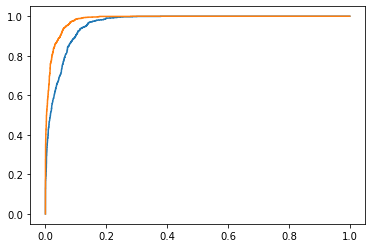

In [81]:
probs_ = lgbm_t.predict_proba(X_test)
preds_ = probs_[:,1]

fpr_, tpr_, thresholds_ = roc_curve(y_test, preds_)

plt.plot(fpr, tpr)
plt.plot(fpr_, tpr_)

<BarContainer object of 56 artists>

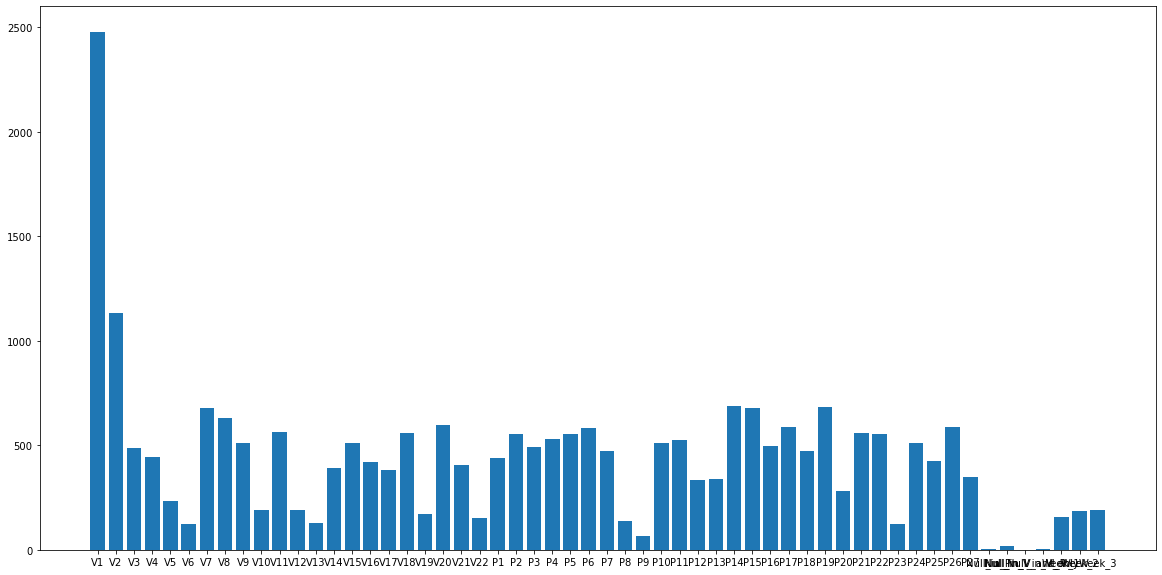

In [130]:
plt.figure(figsize=(20, 10))
plt.bar(train_data_tr.columns, lgbm_t.feature_importances_)

In [ ]:
('V1', 'V2') 0.9802099021826001
('V3', 'V4') 0.9479029782682452
('V3', 'V5') 0.9382264608218077
('V3', 'V6') 0.9429402862640297
('V3', 'V7') 0.9438395296766449
('V3', 'V8') 0.9509793806089359
('V3', 'V9') 0.9509641221547216
('V3', 'V10') 0.951759243769582
('V3', 'V11') 0.9232386257053617
('V3', 'V12') 0.948572413578095
('V3', 'V13') 0.9567393440520954
('V3', 'V14') 0.9207911994873829
('V3', 'V15') 0.9180188587471805
('V3', 'V16') 0.9218178165311288
('V3', 'V17') 0.9437643170838642
('V3', 'V18') 0.9642530118658454
('V3', 'V19') 0.9631200619373619
('V3', 'V20') 0.9652329583637713
('V3', 'V21') 0.9706065452355582
('V3', 'V22') 0.9593838210716663
('V3', 'Null_in_V') -0.9278017831929215
('V3', 'Null_in_V_only') -0.8529345934388698
('V4', 'V5') 0.946350257331713
('V4', 'V6') 0.9488426882544821
('V4', 'V7') 0.969372119848592
('V4', 'V8') 0.9562867446504576
('V4', 'V9') 0.9474473620108197
('V4', 'V10') 0.9636631630109476
('V4', 'V11') 0.9431464122840493
('V4', 'V12') 0.9692837489759966
('V4', 'V13') 0.9458609540533028
('V4', 'V14') 0.9380894223204743
('V4', 'V15') 0.9418935404797344
('V4', 'V16') 0.9290380678771669
('V4', 'V17') 0.9362509823748417
('V4', 'V18') 0.9447691204599067
('V4', 'V19') 0.9473250346530491
('V4', 'V20') 0.9664041434637358
('V4', 'V21') 0.95169368354997
('V4', 'V22') 0.9501786897515061
('V4', 'Null_in_V') -0.9309146476630831
('V4', 'Null_in_V_only') -0.8556129413382911
('V5', 'V6') 0.959596242511467
('V5', 'V7') 0.9509965162112943
('V5', 'V8') 0.952809664972736
('V5', 'V9') 0.9579389948182253
('V5', 'V10') 0.9497833807364737
('V5', 'V11') 0.9471016853464487
('V5', 'V12') 0.9551461076155413
('V5', 'V13') 0.9553729255117158
('V5', 'V14') 0.9463401527373411
('V5', 'V15') 0.9486186813030779
('V5', 'V16') 0.9383069475930812
('V5', 'V17') 0.9404171446545316
('V5', 'V18') 0.9409111383202616
('V5', 'V19') 0.9479627724277805
('V5', 'V20') 0.9491887137033996
('V5', 'V21') 0.9359800988507628
('V5', 'V22') 0.9499792243115337
('V5', 'Null_in_V') -0.9231455609524287
('V5', 'Null_in_V_only') -0.874397022980612
('V6', 'V7') 0.9519365606816761
('V6', 'V8') 0.9552373474150034
('V6', 'V9') 0.9643500010710395
('V6', 'V10') 0.9547962103238449
('V6', 'V11') 0.9567279249113354
('V6', 'V12') 0.9604554192044461
('V6', 'V13') 0.9595010183041941
('V6', 'V14') 0.9528302022276818
('V6', 'V15') 0.9498755863240608
('V6', 'V16') 0.9506113146115157
('V6', 'V17') 0.9453245225405469
('V6', 'V18') 0.9472756208524071
('V6', 'V19') 0.9531083539437655
('V6', 'V20') 0.9522370637724216
('V6', 'V21') 0.9403425561146832
('V6', 'V22') 0.9548844314692538
('V6', 'Null_in_V') -0.9273800477962402
('V6', 'Null_in_V_only') -0.8863982126979977
('V7', 'V8') 0.9798334263664586
('V7', 'V9') 0.9451411918312845
('V7', 'V10') 0.9538459222869513
('V7', 'V11') 0.950606462438447
('V7', 'V12') 0.9595086662738945
('V7', 'V13') 0.9471904063694635
('V7', 'V14') 0.9412057481015771
('V7', 'V15') 0.948337896286852
('V7', 'V16') 0.9339940537131579
('V7', 'V17') 0.9381541213174182
('V7', 'V18') 0.9454914558856493
('V7', 'V19') 0.945518848128762
('V7', 'V20') 0.9789098766851839
('V7', 'V21') 0.9437626562443996
('V7', 'V22') 0.9484245464393647
('V7', 'Null_in_V') -0.9460348626184507
('V7', 'Null_in_V_only') -0.8506820409647552
('V8', 'V9') 0.9518219192319781
('V8', 'V10') 0.9519186938483696
('V8', 'V11') 0.9505068542298937
('V8', 'V12') 0.9560175189649869
('V8', 'V13') 0.952379031909901
('V8', 'V14') 0.9391815250258524
('V8', 'V15') 0.9435080944908355
('V8', 'V16') 0.9433996033856594
('V8', 'V17') 0.9607515780401867
('V8', 'V18') 0.9655756714265914
('V8', 'V19') 0.9487163068226911
('V8', 'V20') 0.9787412343645245
('V8', 'V21') 0.9442759786999136
('V8', 'V22') 0.9508030287564997
('V8', 'Null_in_V') -0.9485118998130383
('V8', 'Null_in_V_only') -0.8555506756059745
('V9', 'V10') 0.9537036587530437
('V9', 'V11') 0.9525849707209172
('V9', 'V12') 0.9591561287718754
('V9', 'V13') 0.965900688108331
('V9', 'V14') 0.947037116949448
('V9', 'V15') 0.9444851339607085
('V9', 'V16') 0.9551626167870193
('V9', 'V17') 0.9535079769429955
('V9', 'V18') 0.9539078603326111
('V9', 'V19') 0.953356032452736
('V9', 'V20') 0.9466806038664194
('V9', 'V21') 0.942479042699909
('V9', 'V22') 0.9528250193854204
('V9', 'Null_in_V') -0.9391872749019798
('V9', 'Null_in_V_only') -0.8569090237670709
('V10', 'V11') 0.9405397139415693
('V10', 'V12') 0.97017695994752
('V10', 'V13') 0.9555908117477693
('V10', 'V14') 0.9403115056958156
('V10', 'V15') 0.9384091912101166
('V10', 'V16') 0.9325503188686144
('V10', 'V17') 0.9399857239645469
('V10', 'V18') 0.9463636639998633
('V10', 'V19') 0.9594936939908291
('V10', 'V20') 0.9577707085741668
('V10', 'V21') 0.9592918856357504
('V10', 'V22') 0.963553821817887
('V10', 'Null_in_V') -0.9246483300164492
('V10', 'Null_in_V_only') -0.875581836056584
('V11', 'V12') 0.9486621125135402
('V11', 'V13') 0.9392239679048736
('V11', 'V14') 0.9692287962876148
('V11', 'V15') 0.9746085245243205
('V11', 'V16') 0.9697276864829771
('V11', 'V17') 0.9393366970382374
('V11', 'V18') 0.9347581322824821
('V11', 'V19') 0.9338961732268246
('V11', 'V20') 0.9412363530830912
('V11', 'V21') 0.9208427298942947
('V11', 'V22') 0.9366102863056593
('V11', 'Null_in_V') -0.9341794843258555
('V11', 'Null_in_V_only') -0.8514528586328174
('V12', 'V13') 0.9580852956475255
('V12', 'V14') 0.948286128637866
('V12', 'V15') 0.9470311476130082
('V12', 'V16') 0.9400177139486042
('V12', 'V17') 0.9444133107159958
('V12', 'V18') 0.948825858954403
('V12', 'V19') 0.956978824199547
('V12', 'V20') 0.9586685948211805
('V12', 'V21') 0.9506414270656639
('V12', 'V22') 0.9586821273962248
('V12', 'Null_in_V') -0.9287951881279688
('V12', 'Null_in_V_only') -0.8844028231609208
('V13', 'V14') 0.939973136831624
('V13', 'V15') 0.9362545992545501
('V13', 'V16') 0.9362320288511757
('V13', 'V17') 0.9447435368030331
('V13', 'V18') 0.9510195183726287
('V13', 'V19') 0.9604205642070914
('V13', 'V20') 0.953011119295804
('V13', 'V21') 0.9484766991903992
('V13', 'V22') 0.9587714352480649
('V13', 'Null_in_V') -0.925643382951703
('V13', 'Null_in_V_only') -0.8831621263002202
('V14', 'V15') 0.9751723262782317
('V14', 'V16') 0.9509883117129346
('V14', 'V17') 0.9311662516161267
('V14', 'V18') 0.9284679305000214
('V14', 'V19') 0.9347035666452168
('V14', 'V20') 0.9351154965173626
('V14', 'V21') 0.9194682338134464
('V14', 'V22') 0.9364753692220449
('V14', 'Null_in_V') -0.9237608295832543
('V14', 'Null_in_V_only') -0.8621854282437333
('V15', 'V16') 0.9498195161874654
('V15', 'V17') 0.9307608258447536
('V15', 'V18') 0.9265649835376606
('V15', 'V19') 0.9314028003967915
('V15', 'V20') 0.9366928532451284
('V15', 'V21') 0.9184769559653531
('V15', 'V22') 0.9339762989581402
('V15', 'Null_in_V') -0.9291386468788307
('V15', 'Null_in_V_only') -0.8496548129448367
('V16', 'V17') 0.9440292936389202
('V16', 'V18') 0.9371296119072462
('V16', 'V19') 0.9277237213330544
('V16', 'V20') 0.9322703669940027
('V16', 'V21') 0.9164465577517068
('V16', 'V22') 0.9304765759033176
('V16', 'Null_in_V') -0.9211934316982097
('V16', 'Null_in_V_only') -0.8513431794367043
('V17', 'V18') 0.9711644718007104
('V17', 'V19') 0.9386320541886867
('V17', 'V20') 0.9479346593745891
('V17', 'V21') 0.9319707319452728
('V17', 'V22') 0.9397102095452396
('V17', 'Null_in_V') -0.9255057989211076
('V17', 'Null_in_V_only') -0.8565454418858827
('V18', 'V19') 0.9477982105258456
('V18', 'V20') 0.963868527827983
('V18', 'V21') 0.9479355345018905
('V18', 'V22') 0.9473915178032207
('V18', 'Null_in_V') -0.9337735575996778
('V18', 'Null_in_V_only') -0.854259790834693
('V19', 'V20') 0.9566861052500564
('V19', 'V21') 0.9655471542243586
('V19', 'V22') 0.9706078050173648
('V19', 'Null_in_V') -0.923557149598108
('V19', 'Null_in_V_only') -0.876969408333565
('V20', 'V21') 0.9623535858754823
('V20', 'V22') 0.9582128371190115
('V20', 'Null_in_V') -0.9489299391751218
('V20', 'Null_in_V_only') -0.8530357268969766
('V21', 'V22') 0.9681134787825731
('V21', 'Null_in_V') -0.9232389036477091
('V21', 'Null_in_V_only') -0.851611646835222
('V22', 'Null_in_V') -0.9250134737988978
('V22', 'Null_in_V_only') -0.8788442940147727
('P1', 'P2') 0.9598569211458253
('P1', 'P3') 0.8821079251627458
('P1', 'P4') 0.9670532339508363
('P1', 'P5') 0.970146369557399
('P1', 'P6') 0.9863553191542878
('P1', 'P7') 0.9792785593647964
('P1', 'P8') 0.7166641027775055
('P1', 'P9') 0.7604655480267423
('P1', 'P10') 0.8250759324047271
('P1', 'P11') 0.8753048315224103
('P1', 'P12') 0.9614872978461861
('P1', 'P13') 0.6573538188924343
('P1', 'P14') 0.9588517289141868
('P1', 'P15') 0.9251386681344007
('P1', 'P16') 0.7917235995209123
('P1', 'P17') 0.9597590936080928
('P1', 'P18') 0.976943475627785
('P1', 'P19') 0.9552411874427402
('P1', 'P20') 0.9610783857751548
('P1', 'P21') 0.968920119683577
('P1', 'P22') 0.9501329322836723
('P1', 'P23') 0.8516673468083535
('P1', 'P24') 0.961451317817465
('P1', 'P25') 0.82901629224771
('P1', 'P26') 0.9768449212010232
('P1', 'P27') 0.9220871974318432
('P1', 'Null_in_P') -0.969595795681974
('P1', 'Null_in_V') -0.5507052338189696
('P1', 'Null_in_V_and_P') -0.969595795681974
('P2', 'P3') 0.9114277590757791
('P2', 'P4') 0.9848104411887894
('P2', 'P5') 0.979797159889938
('P2', 'P6') 0.9734389320778787
('P2', 'P7') 0.9836221478184876
('P2', 'P8') 0.7881904119354305
('P2', 'P9') 0.8233388938631769
('P2', 'P10') 0.8799020917940793
('P2', 'P11') 0.91549473248324
('P2', 'P12') 0.9752896973542393
('P2', 'P13') 0.7702790456050675
('P2', 'P14') 0.9748714412539317
('P2', 'P15') 0.960610540954946
('P2', 'P16') 0.8625051997323888
('P2', 'P17') 0.985604091051188
('P2', 'P18') 0.9913359452956074
('P2', 'P19') 0.9829912107903191
('P2', 'P20') 0.9767921058331109
('P2', 'P21') 0.9841802512943313
('P2', 'P22') 0.991171831575385
('P2', 'P23') 0.8902149632428852
('P2', 'P24') 0.9762561561184195
('P2', 'P25') 0.8499657049942623
('P2', 'P26') 0.9792839404003819
('P2', 'P27') 0.9486850648184003
('P2', 'Null_in_P') -0.9852794015039112
('P2', 'Null_in_V') -0.5950901688524202
('P2', 'Null_in_V_and_P') -0.9852794015039112
('P3', 'P4') 0.9152500923769676
('P3', 'P5') 0.9097254891434816
('P3', 'P6') 0.9039299626714296
('P3', 'P7') 0.8989183181342075
('P3', 'P8') 0.7130620349422752
('P3', 'P9') 0.7471990817823944
('P3', 'P10') 0.842356098132225
('P3', 'P11') 0.8672772223633964
('P3', 'P12') 0.9103119199148884
('P3', 'P13') 0.752477956131351
('P3', 'P14') 0.9070713341382248
('P3', 'P15') 0.8921341906654211
('P3', 'P16') 0.8331463791243866
('P3', 'P17') 0.9178999791699176
('P3', 'P18') 0.907503559870292
('P3', 'P19') 0.9242808800198569
('P3', 'P20') 0.9116190787995889
('P3', 'P21') 0.9250087979476997
('P3', 'P22') 0.9011955235502762
('P3', 'P23') 0.7935454354675197
('P3', 'P24') 0.9111682118008397
('P3', 'P25') 0.7034397705568541
('P3', 'P26') 0.9112390473888133
('P3', 'P27') 0.8637524774509976
('P3', 'Null_in_P') -0.921021882370864
('P3', 'Null_in_V') -0.5588022720442234
('P3', 'Null_in_V_and_P') -0.921021882370864
('P4', 'P5') 0.976271409525529
('P4', 'P6') 0.9816449525321491
('P4', 'P7') 0.9716254454013932
('P4', 'P8') 0.7835699787032534
('P4', 'P9') 0.8254267865140174
('P4', 'P10') 0.8878706688127993
('P4', 'P11') 0.9128563015869002
('P4', 'P12') 0.9885035494423376
('P4', 'P13') 0.8001068096435139
('P4', 'P14') 0.9863681833964673
('P4', 'P15') 0.9490928514939386
('P4', 'P16') 0.8834722921941387
('P4', 'P17') 0.9977877884081012
('P4', 'P18') 0.9832078652351577
('P4', 'P19') 0.9884426247848704
('P4', 'P20') 0.9894634478260329
('P4', 'P21') 0.9942620816674477
('P4', 'P22') 0.9706474495032613
('P4', 'P23') 0.865695636362084
('P4', 'P24') 0.9891819584743178
('P4', 'P25') 0.8590095604068029
('P4', 'P26') 0.9889659498845541
('P4', 'P27') 0.9192216080703554
('P4', 'Null_in_P') -0.9969660542297168
('P4', 'Null_in_V') -0.5915088899724381
('P4', 'Null_in_V_and_P') -0.9969660542297168
('P5', 'P6') 0.9845060579731514
('P5', 'P7') 0.9823077035938341
('P5', 'P8') 0.7627882697006151
('P5', 'P9') 0.8014776976118845
('P5', 'P10') 0.8598972734490528
('P5', 'P11') 0.9024888338956671
('P5', 'P12') 0.9673962728521298
('P5', 'P13') 0.7356730943784264
('P5', 'P14') 0.9696996389934844
('P5', 'P15') 0.9778846648923993
('P5', 'P16') 0.8365953959808802
('P5', 'P17') 0.9739677091203357
('P5', 'P18') 0.9867685149603348
('P5', 'P19') 0.9782251278963363
('P5', 'P20') 0.9681092678657425
('P5', 'P21') 0.9838551412957692
('P5', 'P22') 0.9698543217192996
('P5', 'P23') 0.8682454990504238
('P5', 'P24') 0.9679809224347269
('P5', 'P25') 0.8309977763816941
('P5', 'P26') 0.9789790891559338
('P5', 'P27') 0.9380307447019253
('P5', 'Null_in_P') -0.9797865176936441
('P5', 'Null_in_V') -0.5783427017050471
('P5', 'Null_in_V_and_P') -0.9797865176936441
('P6', 'P7') 0.9795194613036329
('P6', 'P8') 0.7541240631088015
('P6', 'P9') 0.7959696192050357
('P6', 'P10') 0.8532151598563978
('P6', 'P11') 0.8938554745341714
('P6', 'P12') 0.975784321561173
('P6', 'P13') 0.7265687805220771
('P6', 'P14') 0.9738082685619145
('P6', 'P15') 0.9436118474855109
('P6', 'P16') 0.8317075462412229
('P6', 'P17') 0.9754816446478082
('P6', 'P18') 0.9859941169243123
('P6', 'P19') 0.9732242643972621
('P6', 'P20') 0.9757675436318001
('P6', 'P21') 0.9855013569308858
('P6', 'P22') 0.9588237881721062
('P6', 'P23') 0.8579818422103614
('P6', 'P24') 0.97596959063491
('P6', 'P25') 0.8314542035821495
('P6', 'P26') 0.9879947707807587
('P6', 'P27') 0.9227522387657601
('P6', 'Null_in_P') -0.985370965451046
('P6', 'Null_in_V') -0.5626213013816486
('P6', 'Null_in_V_and_P') -0.985370965451046
('P7', 'P8') 0.7534427232417793
('P7', 'P9') 0.7888570089263366
('P7', 'P10') 0.842933991899019
('P7', 'P11') 0.8982605521535152
('P7', 'P12') 0.9628221834090257
('P7', 'P13') 0.688881554219325
('P7', 'P14') 0.9643053792971648
('P7', 'P15') 0.9495909947377886
('P7', 'P16') 0.8065313322813289
('P7', 'P17') 0.9690563183868085
('P7', 'P18') 0.9939998033586387
('P7', 'P19') 0.9684526689633366
('P7', 'P20') 0.9633235327558516
('P7', 'P21') 0.9747922021696321
('P7', 'P22') 0.9828546943148074
('P7', 'P23') 0.8837406341798827
('P7', 'P24') 0.963281491542245
('P7', 'P25') 0.8363788898736989
('P7', 'P26') 0.9756018410720584
('P7', 'P27') 0.9625971815359735
('P7', 'Null_in_P') -0.972509725345035
('P7', 'Null_in_V') -0.5748335830710435
('P7', 'Null_in_V_and_P') -0.972509725345035
('P8', 'P9') 0.9085309132296169
('P8', 'P10') 0.7281153843485384
('P8', 'P11') 0.7412115866017996
('P8', 'P12') 0.7692321605109255
('P8', 'P13') 0.7019834896558107
('P8', 'P14') 0.7725513789468317
('P8', 'P15') 0.7535351882271583
('P8', 'P16') 0.7264267773392971
('P8', 'P17') 0.7857528611188374
('P8', 'P18') 0.7760394849855482
('P8', 'P19') 0.7804459944073465
('P8', 'P20') 0.7716432248351128
('P8', 'P21') 0.7789392581236302
('P8', 'P22') 0.7727281329824527
('P8', 'P23') 0.6773138021471646
('P8', 'P24') 0.770634052444099
('P8', 'P25') 0.6145129324852404
('P8', 'P26') 0.767882824316425
('P8', 'P27') 0.7355294105628315
('P8', 'Null_in_P') -0.7813397319396149
('P8', 'Null_in_V_and_P') -0.7813397319396149
('P9', 'P10') 0.7605480532065141
('P9', 'P11') 0.7727790846721079
('P9', 'P12') 0.8101622530923169
('P9', 'P13') 0.7324614698624851
('P9', 'P14') 0.8142130200792228
('P9', 'P15') 0.7896258013027413
('P9', 'P16') 0.7597462419113716
('P9', 'P17') 0.8263617949890911
('P9', 'P18') 0.8117158963491711
('P9', 'P19') 0.8209781165620682
('P9', 'P20') 0.8126954860504283
('P9', 'P21') 0.8208590572404345
('P9', 'P22') 0.8062396079226122
('P9', 'P23') 0.7078501085077665
('P9', 'P24') 0.8116380307784594
('P9', 'P25') 0.651608709571261
('P9', 'P26') 0.8088538586452979
('P9', 'P27') 0.7638424207533921
('P9', 'Null_in_P') -0.8227272513444547
('P9', 'Null_in_V_and_P') -0.8227272513444547
('P10', 'P11') 0.870057409905712
('P10', 'P12') 0.8820767793278111
('P10', 'P13') 0.770688469672479
('P10', 'P14') 0.874902380385978
('P10', 'P15') 0.855947170836155
('P10', 'P16') 0.87147680390608
('P10', 'P17') 0.8930816115790223
('P10', 'P18') 0.8615154846967452
('P10', 'P19') 0.8907393007701484
('P10', 'P20') 0.8845489552006494
('P10', 'P21') 0.8853873080593042
('P10', 'P22') 0.8670354601010898
('P10', 'P23') 0.7459984139667171
('P10', 'P24') 0.8835469363284901
('P10', 'P25') 0.7606991267094836
('P10', 'P26') 0.872894671508333
('P10', 'P27') 0.8116726079180278
('P10', 'Null_in_P') -0.8913453404905314
('P10', 'Null_in_V') -0.5666940542936131
('P10', 'Null_in_V_and_P') -0.8913453404905314
('P11', 'P12') 0.9051566104782809
('P11', 'P13') 0.7251264136573475
('P11', 'P14') 0.9023473640318938
('P11', 'P15') 0.8896737757619386
('P11', 'P16') 0.839187708957335
('P11', 'P17') 0.9162807270086076
('P11', 'P18') 0.9090190153535055
('P11', 'P19') 0.9156128324108752
('P11', 'P20') 0.9071650133800738
('P11', 'P21') 0.9128369476114253
('P11', 'P22') 0.9063527729091688
('P11', 'P23') 0.7819023742351073
('P11', 'P24') 0.9064027842576813
('P11', 'P25') 0.7775197060256591
('P11', 'P26') 0.9054725624701827
('P11', 'P27') 0.871881881528513
('P11', 'Null_in_P') -0.9149083464534921
('P11', 'Null_in_V') -0.5701258125020374
('P11', 'Null_in_V_and_P') -0.9149083464534921
('P12', 'P13') 0.798626985547277
('P12', 'P14') 0.9760058304905519
('P12', 'P15') 0.9373463004437314
('P12', 'P16') 0.8807236536938956
('P12', 'P17') 0.9856755557070664
('P12', 'P18') 0.9736542488250473
('P12', 'P19') 0.9783637905950806
('P12', 'P20') 0.9994351958836949
('P12', 'P21') 0.9849726641896761
('P12', 'P22') 0.9612087093920472
('P12', 'P23') 0.8541518880413829
('P12', 'P24') 0.9998030189097068
('P12', 'P25') 0.8498635339551989
('P12', 'P26') 0.9827582337234424
('P12', 'P27') 0.9088383500335182
('P12', 'Null_in_P') -0.9911588107115815
('P12', 'Null_in_V') -0.5866523112233174
('P12', 'Null_in_V_and_P') -0.9911588107115815
('P13', 'P14') 0.7830917238853713
('P13', 'P15') 0.7461333555082853
('P13', 'P16') 0.8433430523518762
('P13', 'P17') 0.8064626861544374
('P13', 'P18') 0.7283348864393766
('P13', 'P19') 0.797960009074787
('P13', 'P20') 0.8014119235970264
('P13', 'P21') 0.7907734739934862
('P13', 'P22') 0.74619938386198
('P13', 'P23') 0.6507639581900876
('P13', 'P24') 0.8002275617954435
('P13', 'P25') 0.6754691235755382
('P13', 'P26') 0.7639881489597167
('P13', 'P27') 0.6434439336846828
('P13', 'Null_in_P') -0.8051667742223919
('P13', 'Null_in_V') -0.5061901689231589
('P13', 'Null_in_V_and_P') -0.8051667742223919
('P14', 'P15') 0.9423880154503669
('P14', 'P16') 0.8680205242763948
('P14', 'P17') 0.9837995086000868
('P14', 'P18') 0.9746530681048748
('P14', 'P19') 0.9784681561196624
('P14', 'P20') 0.9769634372415671
('P14', 'P21') 0.9846190052729566
('P14', 'P22') 0.9614541373211658
('P14', 'P23') 0.8570268443027252
('P14', 'P24') 0.9766862694266121
('P14', 'P25') 0.8430860348790986
('P14', 'P26') 0.9784612512756149
('P14', 'P27') 0.9127962656102079
('P14', 'Null_in_P') -0.9853571534172073
('P14', 'Null_in_V') -0.582748905057517
('P14', 'Null_in_V_and_P') -0.9853571534172073
('P15', 'P16') 0.8376647101848116
('P15', 'P17') 0.9518173303980859
('P15', 'P18') 0.9547813116456334
('P15', 'P19') 0.9607401748411495
('P15', 'P20') 0.939417767513193
('P15', 'P21') 0.9572427519239213
('P15', 'P22') 0.955162113303758
('P15', 'P23') 0.8517455992767391
('P15', 'P24') 0.9386356781866162
('P15', 'P25') 0.8168443225164689
('P15', 'P26') 0.9446788696535481
('P15', 'P27') 0.9168370156555289
('P15', 'Null_in_P') -0.9519674480541598
('P15', 'Null_in_V') -0.5853996580488208
('P15', 'Null_in_V_and_P') -0.9519674480541598
('P16', 'P17') 0.8888945593468845
('P16', 'P18') 0.8325574565292934
('P16', 'P19') 0.8833158216787533
('P16', 'P20') 0.8832459178992993
('P16', 'P21') 0.8779485691998717
('P16', 'P22') 0.8456229988378273
('P16', 'P23') 0.7308327855338603
('P16', 'P24') 0.8821740202639018
('P16', 'P25') 0.7634036696799943
('P16', 'P26') 0.8600787192962834
('P16', 'P27') 0.7663054591962186
('P16', 'Null_in_P') -0.8884485569041903
('P16', 'Null_in_V') -0.5614847269047782
('P16', 'Null_in_V_and_P') -0.8884485569041903
('P17', 'P18') 0.9805175418559496
('P17', 'P19') 0.9895401899756385
('P17', 'P20') 0.9870786705380702
('P17', 'P21') 0.9923748995341186
('P17', 'P22') 0.9729241152394077
('P17', 'P23') 0.8686802232346483
('P17', 'P24') 0.9865859372227799
('P17', 'P25') 0.8587397378762494
('P17', 'P26') 0.9849120011803809
('P17', 'P27') 0.9202415316138086
('P17', 'Null_in_P') -0.9947308653800169
('P17', 'Null_in_V') -0.5984359961272824
('P17', 'Null_in_V_and_P') -0.9947308653800169
('P18', 'P19') 0.9775953377661909
('P18', 'P20') 0.9742894460663043
('P18', 'P21') 0.9839478258262374
('P18', 'P22') 0.980908215116603
('P18', 'P23') 0.8828699056708492
('P18', 'P24') 0.9741809263917508
('P18', 'P25') 0.8400173352165975
('P18', 'P26') 0.9851352739696422
('P18', 'P27') 0.9535190940815523
('P18', 'Null_in_P') -0.9836082359321981
('P18', 'Null_in_V') -0.579500229768441
('P18', 'Null_in_V_and_P') -0.9836082359321981
('P19', 'P20') 0.9801091517328737
('P19', 'P21') 0.9950156236847527
('P19', 'P22') 0.9726674527006652
('P19', 'P23') 0.8661511784670105
('P19', 'P24') 0.9794720193957454
('P19', 'P25') 0.8428805627329342
('P19', 'P26') 0.9796641426589836
('P19', 'P27') 0.9226279010257891
('P19', 'Null_in_P') -0.9896176861413202
('P19', 'Null_in_V') -0.5973008879764652
('P19', 'Null_in_V_and_P') -0.9896176861413202
('P20', 'P21') 0.9860042816957133
('P20', 'P22') 0.9629777773650585
('P20', 'P23') 0.8551326745972231
('P20', 'P24') 0.9998396901589538
('P20', 'P25') 0.8506442896763147
('P20', 'P26') 0.9831238248703329
('P20', 'P27') 0.9100448184842811
('P20', 'Null_in_P') -0.9920904698168788
('P20', 'Null_in_V') -0.5888351867947602
('P20', 'Null_in_V_and_P') -0.9920904698168788
('P21', 'P22') 0.9714766961436866
('P21', 'P23') 0.8663632181841365
('P21', 'P24') 0.9857044995935964
('P21', 'P25') 0.8437734711818425
('P21', 'P26') 0.9883695866711874
('P21', 'P27') 0.9231778485931744
('P21', 'Null_in_P') -0.9956389381033537
('P21', 'Null_in_V') -0.5881238406710957
('P21', 'Null_in_V_and_P') -0.9956389381033537
('P22', 'P23') 0.8890448502946002
('P22', 'P24') 0.9623119630394195
('P22', 'P25') 0.8463721141648068
('P22', 'P26') 0.9647534634447598
('P22', 'P27') 0.9546449384293137
('P22', 'Null_in_P') -0.9711559670669189
('P22', 'Null_in_V') -0.5951662163894695
('P22', 'Null_in_V_and_P') -0.9711559670669189
('P23', 'P24') 0.8548597544402777
('P23', 'P25') 0.7563446795503213
('P23', 'P26') 0.860455108732777
('P23', 'P27') 0.8379616358806227
('P23', 'Null_in_P') -0.8626848302808298
('P23', 'Null_in_V') -0.5242698986735413
('P23', 'Null_in_V_and_P') -0.8626848302808298
('P24', 'P25') 0.8504205243305565
('P24', 'P26') 0.9831393227305302
('P24', 'P27') 0.9096530724305825
('P24', 'Null_in_P') -0.9918283132017945
('P24', 'Null_in_V') -0.5878357047555507
('P24', 'Null_in_V_and_P') -0.9918283132017945
('P25', 'P26') 0.8419990855242843
('P25', 'P27') 0.7924513361645256
('P25', 'Null_in_P') -0.8523340083065538
('P25', 'Null_in_V') -0.5403509182284404
('P25', 'Null_in_V_and_P') -0.8523340083065538
('P26', 'P27') 0.9217444201078047
('P26', 'Null_in_P') -0.9915324461472407
('P26', 'Null_in_V') -0.578522817218867
('P26', 'Null_in_V_and_P') -0.9915324461472407
('P27', 'Null_in_P') -0.9189671237339303
('P27', 'Null_in_V') -0.5632569064563282
('P27', 'Null_in_V_and_P') -0.9189671237339303
('Null_in_P', 'Null_in_V') 0.5907163481144873
('Null_in_P', 'Null_in_V_and_P') 1.0
('Null_in_V', 'Null_in_V_and_P') 0.5907163481144874
('Null_in_V', 'Null_in_V_only') 0.724685517741566